# STRAP-LLM Instrumentation — Reasoning Model Walkthrough

This end-to-end notebook demonstrates how to instrument a compact reasoning model with the latest STRAP-LLM features. We'll capture prompt and generation activations, log per-token metadata, benchmark compression strategies, and visualise token-level behaviour for alignment diagnostics.

## Runbook
- Set up libraries and load a reasoning-focused causal language model
- Configure STRAP-LLM for attention-focused prompt capture and full-tensor generation capture
- Record per-token activation streams to JSONL/stream artefacts for offline review
- Compare compression strategies (none, LZ4, Zstd) to balance throughput vs. footprint
- Visualise activation trajectories from `generation_per_token.stream` to spot potential misalignment

In [18]:
# Optional: install extras if running in a fresh environment
# !pip install -U "llm-instrumentation[analysis]" transformers accelerate pandas matplotlib

from pathlib import Path
from datetime import datetime
import json
import math
import os
from typing import Dict

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from llm_instrumentation import (
    InstrumentationFramework,
    InstrumentationConfig,
    HookGranularity,
    analyze_activations_with_tokens,
)
from llm_instrumentation.analysis.visualization import (
    load_stream_packets,
    build_packet_dataframe,
    plot_token_progression,
    visualize_attention_patterns,
)
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Notebook started at: {datetime.utcnow().isoformat()}Z")


def to_device(batch: Dict[str, torch.Tensor], target_device: torch.device):
    """Helper to move tokenized tensors onto the selected device."""
    return {k: v.to(target_device) for k, v in batch.items()}

Using device: cuda
PyTorch version: 2.9.0+cu128
Pandas version: 2.3.3
Notebook started at: 2025-11-04T07:25:51.555558Z


/tmp/ipykernel_73713/3043615.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"Notebook started at: {datetime.utcnow().isoformat()}Z")


## Load a compact reasoning model

The demo uses **Qwen2.5-0.5B-Instruct**, which delivers strong reasoning ability while staying lightweight enough for CPU or single-GPU execution.

In [19]:
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
print(f"Loading model: {MODEL_NAME}")

# Load tokenizer and ensure padding tokens are defined for generate()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model_dtype = torch.float16 if device.type == "cuda" else torch.float32
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=model_dtype,
    trust_remote_code=True,
)
model.to(device)
model.eval()
print("✓ Model ready for inference")

Loading model: Qwen/Qwen3-4B-Instruct-2507


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model ready for inference


## Configure instrumentation profiles

We use two complementary configurations:
- **Attention-only (prompt)**: isolates how the model attends while reading the question.
- **Full tensor (generation)**: streams every activation during reasoning for deeper analysis and per-token tracking.

In [20]:
config_prompt = InstrumentationConfig.attention_analysis()
config_generation = InstrumentationConfig.max_compression().with_granularity(HookGranularity.FULL_TENSOR)

framework_prompt = InstrumentationFramework(config_prompt)
framework_generation = InstrumentationFramework(config_generation)

for framework in (framework_prompt, framework_generation):
    framework.instrument_model(model)

print("✓ Instrumentation frameworks registered")
print(f"Prompt config: granularity={config_prompt.granularity.name}, compression={config_prompt.compression_algorithm}")
print(f"Generation config: granularity={config_generation.granularity.name}, compression={config_generation.compression_algorithm}")

✓ Instrumentation frameworks registered
Prompt config: granularity=ATTENTION_ONLY, compression=lz4
Generation config: granularity=FULL_TENSOR, compression=zstd


## Reasoning prompts

We'll probe different reasoning styles—quantitative, logical, and calendar-style queries—to reveal distinct activation patterns.

In [21]:
prompts = [
    """Think hard about this problem and solve the following problem step-by-step.
A farmer, a sheep and a wolf are standing on one side of a river. There is a boat with enough room for one human and one animal. How can the farmer get across the river with the sheep in the fewest number of trips? 
Note that the wolf cannot be left alone with the sheep.""",
]

for idx, prompt in enumerate(prompts, start=1):
    preview = prompt.splitlines()[0]
    print(f"Prompt {idx}: {preview}")

Prompt 1: Think hard about this problem and solve the following problem step-by-step.


## Prompt-only capture (attention activations)

We first inspect how attention heads process the question before generation. Captured activations land in `prompt_attention.stream`.

In [22]:
prompt_text = prompts[0]
inputs = to_device(tokenizer(prompt_text, return_tensors="pt"), device)
output_path_prompt = Path("prompt_attention.stream")
if output_path_prompt.exists():
    output_path_prompt.unlink()

print(f"Capturing prompt attention activations → {output_path_prompt}")
with framework_prompt.capture_activations(str(output_path_prompt)):
    with torch.no_grad():
        _ = model(**inputs)

analysis_prompt = framework_prompt.analyze_activations(str(output_path_prompt))
print("Prompt capture summary:")
print(json.dumps({k: v for k, v in analysis_prompt.items() if k != "per_layer"}, indent=2))

Capturing prompt attention activations → prompt_attention.stream
Prompt capture summary:
{
  "stream_path": "prompt_attention.stream",
  "compression": "lz4",
  "packets": 0,
  "total_compressed_bytes": 0
}


## Generation capture with per-token tracking

Next we stream the full reasoning trace while tracking each generated token. The stream (`generation_per_token.stream`) is paired with a JSON manifest (`generation_per_token_tokens.json`) that records token ids, text, and capture timing.

In [23]:
generation_prompt = prompts[0]
inputs_generation = to_device(tokenizer(generation_prompt, return_tensors="pt"), device)
max_new_tokens = 10000
output_path_generation = Path("generation_per_token.stream")
if output_path_generation.exists():
    output_path_generation.unlink()

print(f"Generating with per-token tracking → {output_path_generation}")
with framework_generation.capture_activations(
    str(output_path_generation),
    track_per_token=True,
    checkpoint_interval_tokens=125,
) as tracker:
    generation = model.generate(
        **inputs_generation,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        repetition_penalty=1.1,
        temperature=0.8,
        return_dict_in_generate=True,
        pad_token_id=tokenizer.pad_token_id,
    )

    sequence = generation.sequences[0]
    prompt_length = inputs_generation["input_ids"].shape[-1]
    generated_ids = sequence[prompt_length:]

    for position, token_id in enumerate(generated_ids.tolist()):
        token_text = tokenizer.decode([token_id], clean_up_tokenization_spaces=False)
        tracker.record_token(int(token_id), token_text, position=position)

output_text = tokenizer.decode(generation.sequences[0], skip_special_tokens=True)
print("Model output:")
print(output_text)

Generating with per-token tracking → generation_per_token.stream
Model output:
Think hard about this problem and solve the following problem step-by-step.
A farmer, a sheep and a wolf are standing on one side of a river. There is a boat with enough room for one human and one animal. How can the farmer get across the river with the sheep in the fewest number of trips? 
Note that the wolf cannot be left alone with the sheep. 

Let's think through this step by step:

1) The farmer needs to transport himself, the sheep, and the wolf across the river.

2) The boat can carry only one human and one animal at a time.

3) The constraint: the wolf cannot be left alone with the sheep (they would eat each other).

4) We need to minimize the total number of trips (each crossing counts as one trip, regardless of direction).

5) The farmer must go back and forth to bring everyone across.

Let’s consider possible sequences:

Option 1:
- Farmer takes sheep across → now sheep on far side, wolf on near s

## Inspect per-token statistics

`analyze_activations_with_tokens` combines packet metrics with token metadata so we can reason about throughput, bytes-per-token, and layers touched during generation.

In [24]:
analysis_generation = analyze_activations_with_tokens(str(output_path_generation), framework_generation)

summary_keys = [
    "stream_path",
    "compression",
    "packets",
    "total_compressed_bytes",
    "packets_per_token",
    "bytes_per_token",
]
print("Generation capture summary:")
print(json.dumps({k: analysis_generation.get(k) for k in summary_keys}, indent=2))

print("Token metadata preview (first 5 tokens):")
for token in analysis_generation.get("token_metadata", {}).get("tokens", [])[:5]:
    print(token)

Generation capture summary:
{
  "stream_path": "generation_per_token.stream",
  "compression": "zstd",
  "packets": 2152,
  "total_compressed_bytes": 573753284,
  "packets_per_token": 1.0,
  "bytes_per_token": 266613.97955390334
}
Token metadata preview (first 5 tokens):
{'token_index': 0, 'token_id': 4710, 'token_text': ' \n\n'}
{'token_index': 1, 'token_id': 10061, 'token_text': 'Let'}
{'token_index': 2, 'token_id': 594, 'token_text': "'s"}
{'token_index': 3, 'token_id': 1744, 'token_text': ' think'}
{'token_index': 4, 'token_id': 1526, 'token_text': ' through'}


## Compression benchmarking

We replay a short reasoning sample with three compression strategies to compare footprint vs. packet counts. Each run emits `compression_{algo}.stream`.

In [25]:
compression_prompt = prompts[0]
inputs_compression = to_device(tokenizer(compression_prompt, return_tensors="pt"), device)
compression_algorithms = ["none", "lz4", "zstd"]
compression_results = []

for algo in compression_algorithms:
    config = InstrumentationConfig(
        granularity=HookGranularity.FULL_TENSOR,
        compression_algorithm=algo,
        target_throughput_gbps=2.0,
        max_memory_gb=12,
    )
    framework = InstrumentationFramework(config)
    framework.instrument_model(model)

    stream_path = Path(f"compression_{algo}.stream")
    if stream_path.exists():
        stream_path.unlink()

    with framework.capture_activations(str(stream_path)):
        _ = model.generate(
            **inputs_compression,
            max_new_tokens=48,
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.pad_token_id,
        )

    stats = framework.analyze_activations(str(stream_path))
    packets = load_stream_packets(str(stream_path), compression=algo)
    packet_df = build_packet_dataframe(packets)
    mean_ratio = float(packet_df["compression_ratio"].mean()) if not packet_df.empty else float("nan")

    compression_results.append(
        {
            "algorithm": algo,
            "file_size_kb": round(stream_path.stat().st_size / 1024, 2),
            "packets": stats["packets"],
            "total_bytes": stats["total_compressed_bytes"],
            "mean_compression_ratio": round(mean_ratio, 2) if not math.isnan(mean_ratio) else None,
            "bytes_per_packet": round(
                stats["total_compressed_bytes"] / stats["packets"], 2
            ) if stats["packets"] else None,
        }
    )

## Compression results

Higher `mean_compression_ratio` indicates better space savings (uncompressed/compressed). Use this table to balance overhead against quality demands.

In [26]:
compression_df = pd.DataFrame(compression_results).sort_values("mean_compression_ratio", ascending=False)
compression_df.reset_index(drop=True, inplace=True)
compression_df

,algorithm,file_size_kb,packets,total_bytes,mean_compression_ratio,bytes_per_packet
0,zstd,12265.21,48,12558952,1.16,261644.83
1,none,14244.61,48,14585856,1.00,303872.00
2,lz4,14214.40,48,14554921,1.00,303227.52


## Token-level visualisation for misalignment diagnosis

We turn packets from `generation_per_token.stream` into a token-aligned dataframe and plot the activation trajectory. Spikes or heatmap anomalies can hint at misaligned reasoning steps.

In [27]:
packets_generation = load_stream_packets(
    str(output_path_generation), compression=config_generation.compression_algorithm
)
packet_df_generation = build_packet_dataframe(
    packets_generation,
    token_metadata=analysis_generation.get("token_metadata"),
)

print(packet_df_generation.head())

   packet_index layer_name  compressed_bytes  uncompressed_bytes      l2_norm  \
0             0    lm_head            258328              303872  2138.831543   
1             1    lm_head            254751              303872  2817.369629   
2             2    lm_head            263254              303872  1781.870239   
3             3    lm_head            258112              303872  2335.287842   
4             4    lm_head            259472              303872  2330.966309   

       mean       std        max       min  sparsity  compression_ratio  \
0 -4.509345  3.126420  17.625000 -18.37500       0.0           1.176303   
1 -6.221831  3.678527  20.406250 -23.78125       0.0           1.192820   
2 -3.444122  3.005890  27.546875 -16.31250       0.0           1.154292   
3 -4.949012  3.376550  23.453125 -17.59375       0.0           1.177287   
4 -4.798762  3.568324  25.203125 -18.03125       0.0           1.171117   

   token_index token_text  
0            0       \n\n  
1     

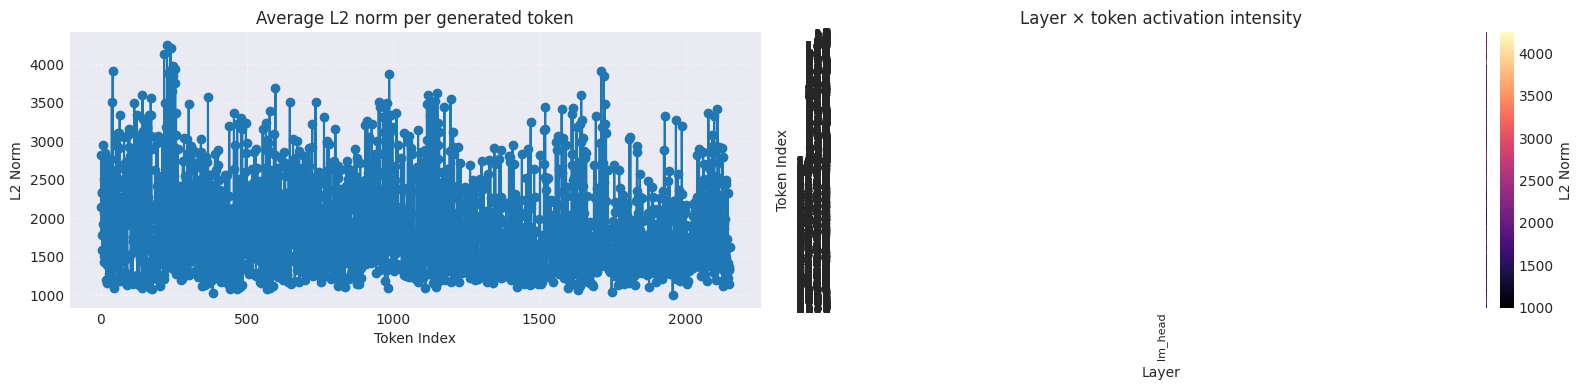

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_token_progression(
    packet_df_generation,
    token_metadata=analysis_generation.get("token_metadata"),
    metric="l2_norm",
    ax=axes[0],
)
axes[0].set_title("Average L2 norm per generated token")

visualize_attention_patterns(
    packet_df_generation,
    token_metadata=analysis_generation.get("token_metadata"),
    metric="l2_norm",
    ax=axes[1],
)
axes[1].set_title("Layer × token activation intensity")
plt.tight_layout()
plt.show()

In [29]:
token_stats = (
    packet_df_generation.groupby(["token_index", "token_text"])["l2_norm"].mean()
    .reset_index()
    .sort_values("l2_norm", ascending=False)
)
print("Top tokens by average L2 norm (potential reasoning pivots):")
print(token_stats.head(10))

Top tokens by average L2 norm (potential reasoning pivots):
      token_index token_text      l2_norm
226           226       Trip  4250.150879
238           238       Trip  4210.812988
216           216       Trip  4127.545410
248           248       Trip  3978.833740
252           252     farmer  3935.663574
242           242     farmer  3931.647705
1711         1711       Trip  3910.621338
40             40     animal  3905.869385
230           230     farmer  3882.151367
986           986     Farmer  3876.163818


## Wrap-up

You now have:
- Prompt and generation activation streams with per-token metadata
- Compression trade-offs logged for fast vs. dense capture
- Token-aligned visualisations to inspect reasoning spikes or misalignment artefacts

Replay the workflow with your own prompts, adjust sampling granularity, or feed the streams into downstream STRAP-LLM analyzers for deeper circuit discovery.

In [30]:
print("Artifacts generated:")
token_manifest_path = output_path_generation.with_name(output_path_generation.stem + "_tokens.json")
for path in [output_path_prompt, output_path_generation, token_manifest_path]:
    exists = path.exists()
    size = f"{path.stat().st_size / 1024:.2f} KB" if exists else "missing"
    state = 'present' if exists else 'missing'
    print(f"- {path.name}: {state} ({size})")

Artifacts generated:
- prompt_attention.stream: present (0.00 KB)
- generation_per_token.stream: present (560333.26 KB)
- generation_per_token_tokens.json: present (190.41 KB)


## Análisis de Activaciones por Token

Puedes analizar cómo cambian las activaciones internas del modelo para cada token generado. Esto te permite identificar:
- Circuitos específicos que se activan para diferentes tipos de tokens
- Patrones de atención que muestran qué tokens anteriores influyen en la generación actual
- Características monosemánticas: neuronas que se especializan en conceptos específicos


### Visualizaciones Efectivas

1. **Mapas de Calor de Atención**: Visualiza patrones de atención por capa y cabeza para detectar dependencias clave entre tokens.
2. **Análisis de Flujo de Información**: Siguiendo las técnicas de Sparse Tracing, identifica las rutas más importantes de información, qué tokens actúan como "anclas" influyendo en múltiples generaciones futuras y cómo se propaga la información a través de las capas.
3. **Detección de Circuitos**: Identifica circuitos computacionales específicos rastreando qué componentes se co-activan y cómo contribuyen a la funcionalidad global.


In [31]:

import numpy as np
import seaborn as sns

# Visualizar patrones de atención por capa y cabeza usando capturas reales
# Acepta tanto listas de paquetes como DataFrames ya construidos
# Calcula la intensidad media por token para cada capa y despliega los
# ocho patrones más dinámicos para inspección rápida.
def visualize_attention_patterns(
    activations,
    token_metadata=None,
    metric="l2_norm",
    layers_per_row=4,
    max_layers=8,
):
    if isinstance(activations, list):
        packet_stats = build_packet_dataframe(activations, token_metadata)
    else:
        packet_stats = activations.copy()

    if token_metadata and "token_index" not in packet_stats.columns:
        packet_stats = build_packet_dataframe(packet_stats.to_dict("records"), token_metadata)

    if "token_index" not in packet_stats.columns:
        raise ValueError(
            "El DataFrame de activaciones necesita la columna 'token_index'. "
            "Asegúrate de invocar analyze_activations_with_tokens antes."
        )

    pivot = (
        packet_stats
        .pivot_table(index="token_index", columns="layer_name", values=metric, aggfunc="mean")
        .sort_index()
        .fillna(0.0)
    )
    if pivot.empty:
        raise ValueError("No hay datos suficientes para construir el mapa de calor de atención.")

    variance_order = pivot.var(axis=0).sort_values(ascending=False)
    selected_layers = variance_order.head(max_layers).index.tolist()
    if not selected_layers:
        raise ValueError("No se identificaron capas con variabilidad suficiente en las activaciones.")

    rows = int(np.ceil(len(selected_layers) / layers_per_row)) or 1
    fig, axes = plt.subplots(rows, layers_per_row, figsize=(5 * layers_per_row, 2.5 * rows))
    axes = np.atleast_1d(axes).reshape(rows, layers_per_row)

    token_labels = None
    if token_metadata and token_metadata.get("tokens"):
        tokens = token_metadata["tokens"]
        token_labels = [
            (tokens[idx].get("token_text", "").strip() or f"#{idx}")
            if 0 <= idx < len(tokens)
            else f"#{idx}"
            for idx in pivot.index
        ]

    for idx in range(rows * layers_per_row):
        ax = axes[idx // layers_per_row, idx % layers_per_row]
        if idx >= len(selected_layers):
            ax.axis("off")
            continue

        layer = selected_layers[idx]
        layer_values = pivot[[layer]]
        normalized = (layer_values - layer_values.min()) / (layer_values.max() - layer_values.min() + 1e-9)

        sns.heatmap(
            normalized.T,
            cmap="magma",
            cbar=idx == 0,
            ax=ax,
            cbar_kws={"label": f"{metric.replace('_', ' ').title()} (normalizado)"} if idx == 0 else None,
        )
        ax.set_ylabel(layer)
        ax.set_xlabel("Índice de token")

        if token_labels is not None and len(token_labels) <= 40:
            ax.set_xticks(np.arange(len(token_labels)) + 0.5)
            ax.set_xticklabels(token_labels, rotation=45, ha="right", fontsize=9)
        else:
            ax.set_xticks(np.linspace(0.5, len(pivot.index) - 0.5, num=min(10, len(pivot.index))))
            ax.set_xticklabels([f"#{int(x)}" for x in np.linspace(0, len(pivot.index) - 1, num=min(10, len(pivot.index)))], rotation=0)

        ax.set_yticks([])

    fig.tight_layout()
    return fig


### Análisis de Flujo de Información

Siguiendo las técnicas de Sparse Tracing, puedes identificar las rutas más importantes de información:
- Qué tokens actúan como "anclas" influyendo en múltiples generaciones futuras
- Cómo se propaga la información a través de las capas


### Detección de Circuitos

Identifica circuitos computacionales específicos y mapea la funcionalidad de cada componente clave.


In [32]:

import numpy as np
from itertools import combinations

# Analiza co-activaciones entre capas para descubrir circuitos candidatos
# Devuelve un DataFrame con las parejas más correlacionadas y los tokens
# que actúan como anclas compartidas.
def analyze_circuits(
    activations,
    tokens,
    metric="l2_norm",
    min_correlation=0.6,
    top_k=8,
):
    if isinstance(activations, list):
        packet_stats = build_packet_dataframe(activations, tokens)
    else:
        packet_stats = activations.copy()

    if "token_index" not in packet_stats.columns:
        raise ValueError(
            "Se requieren índices de token para analizar circuitos. "
            "Vuelve a generar el DataFrame con token_metadata."
        )

    pivot = (
        packet_stats
        .pivot_table(index="token_index", columns="layer_name", values=metric, aggfunc="mean")
        .sort_index()
        .fillna(0.0)
    )
    if pivot.empty or pivot.shape[1] < 2:
        return pd.DataFrame(columns=["layer_a", "layer_b", "correlation", "anchor_tokens"])

    normalized = (pivot - pivot.min()) / (pivot.max() - pivot.min() + 1e-9)
    correlations = normalized.corr()

    token_list = []
    if tokens and isinstance(tokens, dict) and tokens.get("tokens"):
        token_list = tokens["tokens"]

    circuit_records = []
    for layer_a, layer_b in combinations(correlations.columns, 2):
        value = correlations.loc[layer_a, layer_b]
        if np.isnan(value) or abs(value) < min_correlation:
            continue

        joint_strength = (normalized[layer_a] * normalized[layer_b]).sort_values(ascending=False)
        top_indices = joint_strength.head(3).index.tolist()

        anchor_tokens = []
        for idx in top_indices:
            if token_list and 0 <= idx < len(token_list):
                token_text = token_list[idx].get("token_text", "").strip()
                anchor_tokens.append(token_text or f"#{idx}")
            else:
                anchor_tokens.append(f"#{idx}")

        circuit_records.append(
            {
                "layer_a": layer_a,
                "layer_b": layer_b,
                "correlation": float(value),
                "anchor_tokens": ", ".join(anchor_tokens),
            }
        )

    if not circuit_records:
        return pd.DataFrame(columns=["layer_a", "layer_b", "correlation", "anchor_tokens"])

    circuits = pd.DataFrame(circuit_records).sort_values("correlation", ascending=False)
    if top_k:
        circuits = circuits.head(top_k)
    return circuits.reset_index(drop=True)


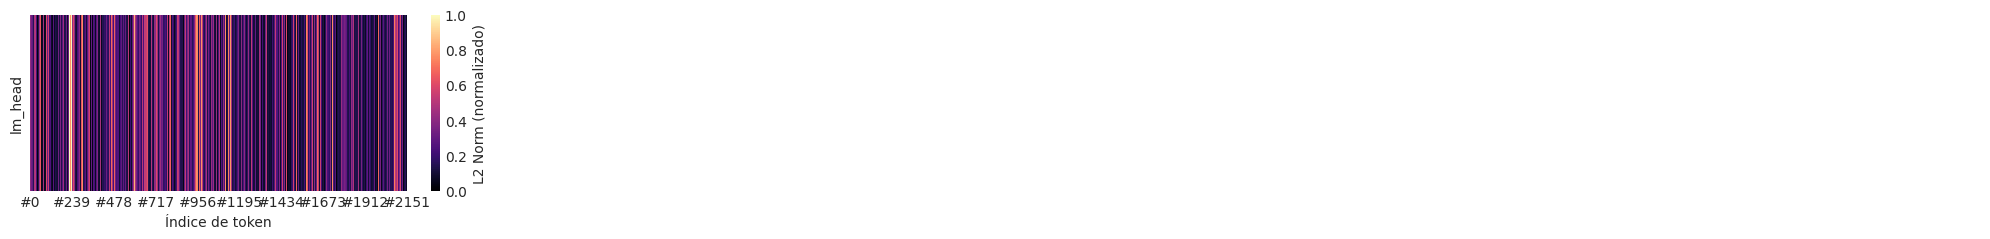

Top circuit candidates (by correlated layers):


,layer_a,layer_b,correlation,anchor_tokens


In [33]:
# Ejecuta las visualizaciones avanzadas usando las activaciones generadas
advanced_fig = visualize_attention_patterns(
    packet_df_generation,
    token_metadata=analysis_generation.get("token_metadata"),
    metric="l2_norm",
    layers_per_row=4,
    max_layers=8,
)
plt.show()

circuit_summary = analyze_circuits(
    packet_df_generation,
    tokens=analysis_generation.get("token_metadata"),
    metric="l2_norm",
    min_correlation=0.65,
    top_k=10,
)
print("Top circuit candidates (by correlated layers):")
circuit_summary


### Herramientas Específicas para tu Análisis

- **Análisis de Características Dispersas**: Usa técnicas como Sparse Autoencoders (SAEs) para descomponer activaciones en características interpretables, identificar conceptos específicos aprendidos por el modelo y analizar cómo se combinan esas características.
- **Visualización Interactiva**: Considera herramientas como PyGWalker para exploración interactiva de datos, Plotly/Dash para dashboards en tiempo real y visualizaciones personalizadas que muestren la evolución token por token.


### Análisis Específicos Recomendados

1. **Análisis de Diversidad por Capas**: Implementa la descomposición bias-diversidad para entender cómo cada capa contribuye a la predicción final, qué tan diversas son las representaciones entre capas y dónde ocurren los cambios más significativos en el procesamiento.
2. **Detección de Patrones de Razonamiento**: Si tu modelo hace *chain-of-thought reasoning*, identifica "thought anchors" (tokens clave que guían el razonamiento), mapea cómo se construye el razonamiento paso a paso y detecta cuándo el modelo cambia entre razonamiento y memorización.
3. **Análisis de Alucinaciones**: Usando técnicas similares a ReDeEP, analiza cuándo las FFN enfatizan conocimiento paramétrico frente a externo, cómo las "Copying Heads" integran información contextual y qué patrones predicen comportamientos problemáticos.
